In [3]:
%matplotlib inline

import datetime
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

# How to enable Colab GPUs https://colab.research.google.com/notebooks/gpu.ipynb
# Select the Runtime > "Change runtime type" menu to enable a GPU accelerator,
# and then re-execute this cell.
if 'google.colab' in str(get_ipython()):
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))

import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, Conv1D, BatchNormalization, GlobalAveragePooling1D, Flatten, Reshape
from keras.optimizers import Adam, Adadelta
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reduces variance in results but won't eliminate it :-(
%env PYTHONHASHSEED=0
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

env: PYTHONHASHSEED=0


# Keras Neural Networks for Weather Time Series Nowcasts

Building neural networks with [keras](https://keras.io/) for time series analysis of Cambridge UK weather data,
using a streamlined version of data preparation from 
[Tensorflow time series forecasting tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series).


## Import Data

Data has been cleaned but may still have issues.  See the 
[cleaning section](https://github.com/makeyourownmaker/CambridgeTemperatureModel#Cleaning)
in the 
[Cambridge Temperature Model](https://github.com/makeyourownmaker/CambridgeTemperatureModel)
repository for details.

The `y` variable is temperature * 10.  I'm primarily interested in short term temperature forecasts (less than 2 hours).  Observations occur every 30 mins.

In [4]:
if 'google.colab' in str(get_ipython()):
    data_loc = "https://github.com/makeyourownmaker/CambridgeTemperatureModel/blob/master/data/CamUKWeather.csv?raw=true"
else:
    data_loc = "../data/CamUKWeather.csv"
df = pd.read_csv(data_loc, parse_dates = True)

df['ds'] = pd.to_datetime(df['ds'])

print("Shape:")
print(df.shape)
print("\nInfo:")
print(df.info())
print("\nSummary stats:")
display(df.describe())
print("\nRaw data:")
df

Shape:
(192885, 11)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192885 entries, 0 to 192884
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ds                 192885 non-null  datetime64[ns]
 1   year               192885 non-null  int64         
 2   doy                192885 non-null  int64         
 3   time               192885 non-null  object        
 4   y                  192885 non-null  int64         
 5   humidity           192885 non-null  int64         
 6   dew.point          192885 non-null  int64         
 7   pressure           192885 non-null  int64         
 8   wind.speed.mean    192885 non-null  int64         
 9   wind.bearing.mean  192885 non-null  int64         
 10  wind.speed.max     192885 non-null  int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 16.2+ MB
None

Summary stats:


,year,doy,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean,wind.speed.max
count,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000
mean,2013.895803,186.882298,101.096819,79.239951,62.135174,1014.404153,44.588148,196.223423,117.140369
std,3.283992,106.486420,64.465602,16.908724,51.016879,11.823922,40.025546,82.458390,80.116199
min,2008.000000,1.000000,-138.000000,25.000000,-143.000000,963.000000,0.000000,0.000000,0.000000
25%,2011.000000,94.000000,52.000000,69.000000,25.000000,1008.000000,12.000000,135.000000,60.000000
50%,2014.000000,191.000000,100.000000,83.000000,64.000000,1016.000000,35.000000,225.000000,100.000000
75%,2017.000000,280.000000,145.000000,92.000000,100.000000,1023.000000,67.000000,270.000000,160.000000
max,2020.000000,366.000000,361.000000,100.000000,216.000000,1048.000000,291.000000,315.000000,580.000000



Raw data:


,ds,year,doy,time,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean,wind.speed.max
0,2008-08-01 08:30:00,2008,214,09:30:00,186,69,128,1010,123,180,280
1,2008-08-01 09:00:00,2008,214,10:00:00,191,70,135,1010,137,180,260
2,2008-08-01 09:30:00,2008,214,10:30:00,195,68,134,1010,133,180,260
3,2008-08-01 10:00:00,2008,214,11:00:00,200,68,139,1010,129,180,240
4,2008-08-01 10:30:00,2008,214,11:30:00,213,61,135,1010,145,180,260
...,...,...,...,...,...,...,...,...,...,...,...
192880,2020-01-16 00:00:00,2020,16,00:00:00,40,78,5,1017,45,180,100
192881,2020-01-16 00:30:00,2020,16,00:30:00,36,86,15,1018,25,180,120
192882,2020-01-16 01:00:00,2020,16,01:00:00,36,85,13,1018,28,180,80
192883,2020-01-16 01:30:00,2020,16,01:30:00,36,82,8,1018,17,180,80


May end up with more neural network parameters than data!

---

## Feature Engineering

The data must be reformatted before model building.

The following steps are necessary:
 * Wind direction and speed transformation
 * Impute missing data where possible
 * Time conversion
 * Split data
 * Normalise data
 * Window data


### Wind direction and speed transformation

The `wind.bearing.mean` column gives wind direction in degrees but is categorised at 45 degree increments, 
i.e. 0, 45, 90, 135, 180, 225, 270, 315.  Wind direction shouldn't matter if the wind is not blowing.

The distribution of wind direction and speed looks like this:

In [79]:
plt.hist2d(df['wind.bearing.mean'], df['wind.speed.mean'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind Direction (deg)')
plt.ylabel('Wind Velocity (Knots * 10)');

KeyError: 'wind.bearing.mean'

Convert wind direction and speed to _x_ and _y_ vectors, so the model can more easily interpret them.

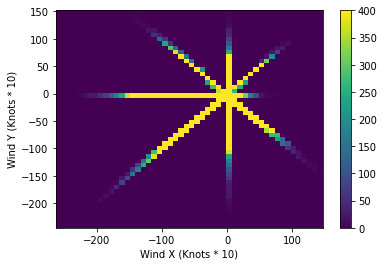

In [6]:
wv = df['wind.speed.mean']
max_wv = df['wind.speed.max']

# Convert to radians
wd_rad = df['wind.bearing.mean'] * np.pi / 180

# Calculate the wind x and y components
df['wind.x'] = wv * np.cos(wd_rad)
df['wind.y'] = wv * np.sin(wd_rad)

# Calculate the max wind x and y components
df['max.wind.x'] = max_wv * np.cos(wd_rad)
df['max.wind.y'] = max_wv * np.sin(wd_rad)

df_orig = df

plt.hist2d(df['wind.x'], df['wind.y'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind X (Knots * 10)')
plt.ylabel('Wind Y (Knots * 10)');

Better, but not ideal.  Some data augmentation with a method like 
[mixup](https://arxiv.org/abs/1710.09412) may be beneficial.


### Missing value interpolation

Missing data is much less of a problem for [prophet models](https://github.com/makeyourownmaker/BayesianProphet)
which handle it seamlessly.

Currently around 8,000 missing observations in approx. 600 sections or "gaps".
The gaps range in length from 30 mins to 45 days.

Gaps occur equally across all variables, i.e. if there is a gap of length 6 (3 hours) then all variables are missing for 6 consecutive observations.

Missing observations can be [imputed](https://en.wikipedia.org/wiki/Imputation_(statistics)).  
Here I use a variation on
[cubic interpolation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.PchipInterpolator.html).
Vanilla cubic interpolation overshoots the data which introduces outlier values.
I limit the gap length to 12 observations (6 hours).

Which removes 23 % of gaps.

Longer gaps will be accounted for at the train, test, validation split stage.

/usr/local/lib/python3.8/site-packages/scipy/interpolate/_cubic.py:288: RuntimeWarning: invalid value encountered in add
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


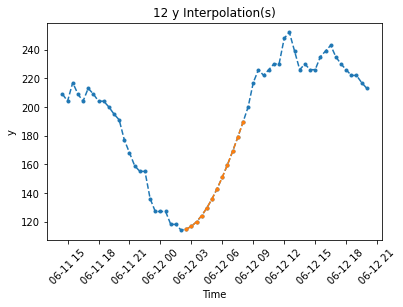

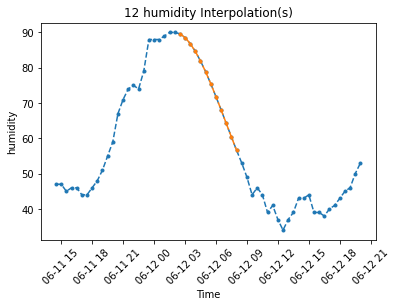

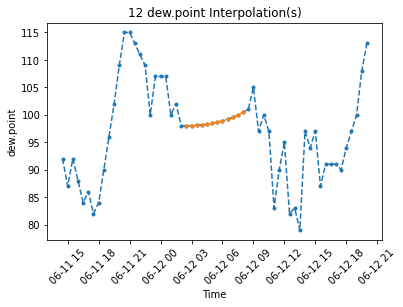

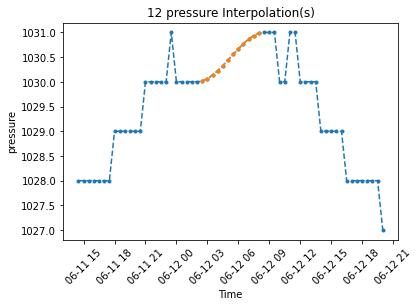

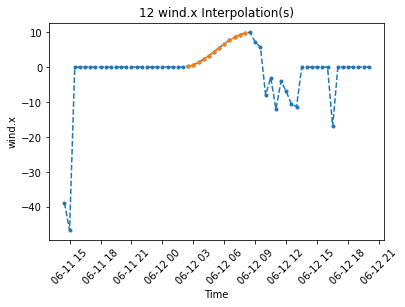

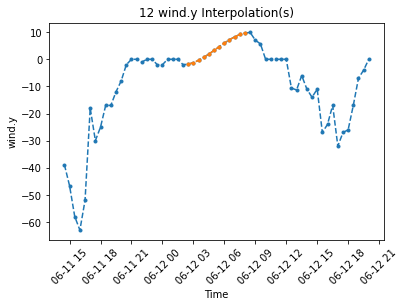

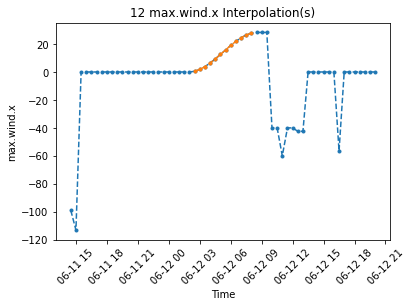

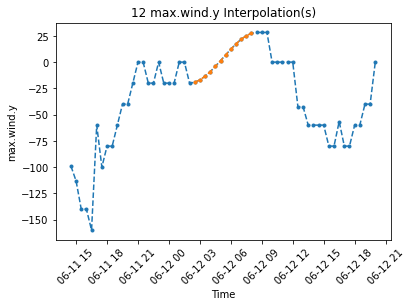

In [36]:
del_cols = ['doy', 'wind.bearing.mean', 'wind.speed.mean', 'wind.speed.max']
df_ts = df_orig.set_index('ds', drop = False)
df_ts.drop(del_cols, axis = 1, inplace = True)

# Add NaN values for missing observations
df_ts_na = df_ts.asfreq('30min')

# Set NaN year, time values using index
df_ts_na.ds   = df_ts_na.index
df_ts_na.year = df_ts_na.index.year
df_ts_na.time = df_ts_na.index.time

# Count number of consecutive missing values
#   There are more elegant ways to do this but they don't cope well with NaNs
#   As far as I can tell, neither numpy nor pandas have native run length encoding functions!?
len_holes = pd.Series([len(list(g)) for k, g in itertools.groupby(df_ts_na.y.isnull()) if k])
len_holes_long = pd.Series(list(itertools.repeat(l, l)) for l in len_holes)
len_holes_flat = pd.Series(list(itertools.chain(*len_holes_long)))

df_ts_na['missing_len'] = -100
df_ts_na['missing_len'] = df_ts_na['missing_len'].astype('Int64')
df_ts_na.loc[df_ts_na.y.isnull(), 'missing_len'] = len_holes_flat.to_numpy()

# Mark 24 observations before and after each group of NaNs
df_ts_na['around_nan'] = -100
df_ts_na['around_nan'] = df_ts_na['around_nan'].astype('Int64')

for i in range(-24, 25):
    df_ts_na.loc[df_ts_na.y.isna().shift(i).fillna(False), 'around_nan'] = i
    
df_ts_na.loc[df_ts_na.y.isna(), 'around_nan'] = 0


# Interpolate - method = 'spline' very slow :-(
#               cubic and quadratic overshoot the data and introduce outliers
limit  = 12
method = 'pchip'
for v in ['y', 'humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y', 'max.wind.x', 'max.wind.y']:
    df_ts_na[v] = df_ts_na[v].interpolate(method = method, limit = limit)


# Extract missing observations and surrounding values into dict of lists for checking & plotting
# gonna be slow :-(
j = miss_len = 0
inner_list = []
miss_plus  = {}
for index, row in df_ts_na.iterrows():
    if (row['around_nan'] > -25) | (row['missing_len'] > 0):
        inner_list.append(index)
        if row['missing_len'] > 0:
            miss_len = row['missing_len']
        j  = 1
    else:
        if j == 1:
            miss_plus.setdefault(miss_len, []).append(inner_list)
            inner_list = []
        j = miss_len = 0

#print("keys: ",  len(miss_plus.keys()))
#print("sum:  ",  sum(miss_plus.keys()))
#print("keys:  ", sorted(miss_plus.keys()))
#print(len(miss_plus[29]))
#print(len(miss_plus[29][0]))
#print(miss_plus[29][0])
#df_ts_na.loc[miss_plus[29][0]]        

def plot_interpolation(data, variable):
    marks = data.loc[data.missing_len > 0, variable]
    title = str(len(marks)) + ' ' + variable + ' Interpolation(s)'
    
    plt.figure()
    plt.plot(data[variable], marker = '.', linestyle = '--')
    plt.plot(marks, marker = '.', linestyle = '--')
    plt.xticks(rotation = 45)
    plt.title(title)
    plt.ylabel(variable)
    plt.xlabel('Time')

for v in ['y', 'humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y', 'max.wind.x', 'max.wind.y']:
    plot_interpolation(df_ts_na.loc[miss_plus[12][1]], v)


# Remove gaps longer than 12
df_ts_na = df_ts_na.dropna()
drop_cols = ['missing_len', 'around_nan']
df_ts_na.drop(drop_cols, axis = 1, inplace = True)
df = df_ts_na

After all that, there is a 23 % reduction in missing values.

Alternative interpolation methods (piecewise methods in particular) may give more natural results for the wind and pressure variables.


### Time conversion

Convert `ds` timestamps to "time of day" and "time of year" variables using `sin` and `cos`.

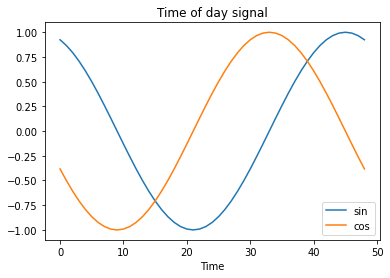

In [37]:
# Convert to secs
date_time   = pd.to_datetime(df['ds'], format = '%Y.%m.%d %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)

day  = 24 * 60 * 60
year = (365.2425) * day

df['day.sin']  = np.sin(timestamp_s * (2 * np.pi / day))
df['day.cos']  = np.cos(timestamp_s * (2 * np.pi / day))
df['year.sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year.cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df['day.sin'])[:49])
plt.plot(np.array(df['day.cos'])[:49])
plt.xlabel('Time')
plt.legend(['sin', 'cos'], loc = 'lower right')
plt.title('Time of day signal');

### Split data

Use data from 2018 for validation and 2019 for testing.  These are entirely arbitrary choices.
This results in an approximate 82%, 9%, 9% split for the training, validation, and test sets.

In [38]:
keep_cols = ['y', 'humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y',
             'day.sin', 'day.cos', 'year.sin', 'year.cos']
del_cols = ['ds', 'time', 'max.wind.x', 'max.wind.y']
df.drop(del_cols, axis = 1, inplace = True)

train_df = df.loc[(df['year'] != 2018) & (df['year'] != 2019)]
valid_df = df.loc[df['year'] == 2018]
test_df  = df.loc[df['year'] == 2019]

train_df = train_df.drop('year', axis = 1)  # inplace=True gives SettingWithCopyWarning
valid_df = valid_df.drop('year', axis = 1)  # ...
test_df  = test_df.drop('year',  axis = 1)
df       = df.drop('year',       axis = 1)

print("df.drop shape: ", df.shape)
print("train shape:   ", train_df.shape)
print("valid shape:   ", valid_df.shape)
print("test shape:    ", test_df.shape)

df.drop shape:  (194736, 10)
train shape:    (160059, 10)
valid shape:    (17236, 10)
test shape:     (17441, 10)


### Normalise data

Features should be scaled before neural network training.  Arguably, scaling should be done using moving averages to avoid accessing future values.  
Instead, simple [standard score](https://en.wikipedia.org/wiki/Standard_score) 
normalisation will be used.

Plot [violin plot](https://en.wikipedia.org/wiki/Violin_plot) 
to see distribution of features.

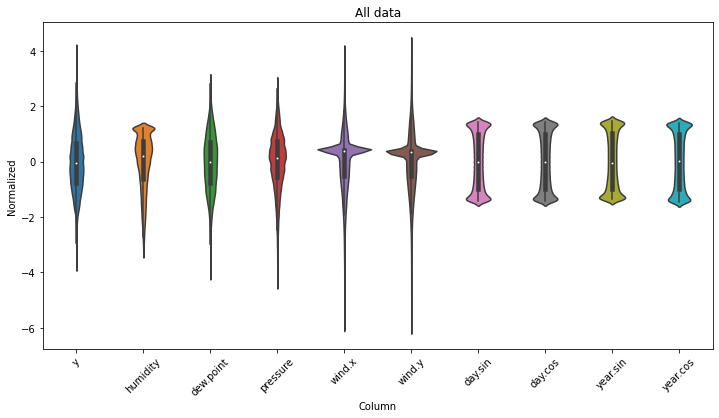

In [39]:
train_mean = train_df.mean()
train_std  = train_df.std()

train_df = (train_df - train_mean) / train_std
valid_df = (valid_df - train_mean) / train_std
test_df  = (test_df  - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name = 'Column', value_name = 'Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x = 'Column', y = 'Normalized', data = df_std)
ax.set_xticklabels(df.keys(), rotation = 45)
ax.set_title('All data');

There may still be some outliers present but there are no glaring problems.


### Window data

Models are trained using sliding windows of samples from the data.

Window parameters to consider for the 
[tf.keras.preprocessing.timeseries_dataset_from_array](https://keras.io/api/preprocessing/timeseries/#timeseries-data-preprocessing)
function:
 * sequence_length: 
   * Length of the output sequences (in number of timesteps), or number of **lag** observations to use
 * sequence_stride: 
   * Period between successive output sequences.  For stride s, output samples start at index data[i], data[i + s], data[i + 2 * s] etc
   * s can include an **offset** and/or 1 or more **steps ahead** to forecast
 * batch_size: 
   * Number of samples in each batch
 * shuffle: 
   * Shuffle output samples, or use chronological order
 
Initial values used:
 * sequence_length (aka lags): 4
 * steps ahead (what to forecast): 1 and separately 4
 * offset (space between lags and steps ahead): 0
 * batch_size: 32
 * shuffle: True
 
The lags, batch_size and shuffle values may be optimised later.

The `make_dataset` function below generates [tensorflow datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for:
 * Lags, steps-ahead, offset, batch size and shuffle
 * Optionally multiple y columns (Not extensively tested)
 
Stride is used to specify offset + steps-ahead.  Offset will be 0 throughout this notebook.

**TODO** Insert figure illustrating lags, offsets and steps-ahead.

First, check results are as expected for single batch with `shuffle = False`.
Then, process all training data with `shuffle = True`.

In [67]:
data = train_df

# Add NaN values for missing observations
data = data.asfreq('30min')
    
#data_np = np.array(data, dtype = np.float32)
data_np = data.head(5000)

#print(data_np)
#print(data_np.shape)
    
# Split data into subsets (blocks) on NaNs - https://stackoverflow.com/a/21404655/100129
blocks = np.split(data_np, np.where(np.isnan(data_np.y))[0])
# removing NaN entries
blocks = [bl[~np.isnan(bl.y)] for bl in blocks if not isinstance(bl, np.ndarray)]
# removing empty DataFrames
blocks = [bl for bl in blocks if not bl.empty]

#print(len(blocks))
#for bl in blocks:
#    print(bl.shape)

def make_dataset(data, y_cols, lags = 1, steps_ahead = 1, stride = 1, bs = 32, shuffle = False):    
    assert stride >= steps_ahead

    total_window_size = lags + stride
    
    # Add NaN values for missing observations
    data = data.asfreq('30min')
    
    # Split data into subsets (blocks) on NaNs - https://stackoverflow.com/a/21404655/100129
    blocks = np.split(data, np.where(np.isnan(data.y))[0])
    # removing NaN entries
    blocks = [bl[~np.isnan(bl.y)] for bl in blocks if not isinstance(bl, np.ndarray)]
    # removing empty DataFrames
    blocks = [bl for bl in blocks if not bl.empty]
    
    i = 0    
    for block in blocks:
        i += 1
        block_np = np.array(block, dtype = np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
               data    = block_np,
               targets = None,
               sequence_length = total_window_size,
               sequence_stride = 1,
               shuffle    = shuffle,
               batch_size = bs)
            
        col_indices = {name: i for i, name in enumerate(data.columns)}    
        X_slice = slice(0, lags)
        y_start = total_window_size - steps_ahead
        y_slice = slice(y_start, None)

    
        def split_window(features):   
            X = features[:, X_slice, :]
            y = features[:, y_slice, :]

            X = tf.stack(
                [X[:, :, col_indices[name]] for name in data.columns],
                axis = -1)    
            y = tf.stack(
                [y[:, :, col_indices[name]] for name in y_cols],
                axis = -1)

            # Slicing doesn't preserve static shape information, so set the shapes manually.
            # This way the `tf.data.Datasets` are easier to inspect.
            X.set_shape([None, lags,        None])
            y.set_shape([None, steps_ahead, None])

            return X, y

    
        ds = ds.map(split_window)
        
        if i == 1:
            combined_dataset = ds
        else:
            combined_dataset = combined_dataset.concatenate(ds)
        
    return combined_dataset

foo = make_dataset(train_df.head(5000), 'y', lags = 1, steps_ahead = 1, stride = 1, bs = 32, shuffle = False)
dataset_sanity_checks(foo, '1l 1s foo');

1l 1s foo batches:  157
	X (batch_size, time, features):  (32, 1, 10)
	y (batch_size, time, features):  (32, 1, 1)
	X[0][0]:  tf.Tensor(
[[ 1.305531   -0.64088255  1.2489514  -0.38158447 -2.5459762   0.35051006
   1.3080385  -0.54185224 -0.65950835 -1.2607328 ]], shape=(1, 10), dtype=float32)
	y[0][0]:  tf.Tensor([[1.3836545]], shape=(1, 1), dtype=float32)


In [71]:
def make_dataset_orig(data, y_cols, lags = 1, steps_ahead = 1, stride = 1, bs = 32, shuffle = False):    
    assert stride >= steps_ahead

    total_window_size = lags + stride
    
    data_np = np.array(data, dtype = np.float32)    
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
           data    = data_np,
           targets = None,
           sequence_length = total_window_size,
           sequence_stride = 1,
           shuffle    = shuffle,
           batch_size = bs)
            
    col_indices = {name: i for i, name in enumerate(data.columns)}    
    X_slice = slice(0, lags)
    y_start = total_window_size - steps_ahead
    y_slice = slice(y_start, None)

    
    def split_window(features):   
        X = features[:, X_slice, :]
        y = features[:, y_slice, :]

        X = tf.stack(
            [X[:, :, col_indices[name]] for name in data.columns],
            axis = -1)    
        y = tf.stack(
            [y[:, :, col_indices[name]] for name in y_cols],
            axis = -1)

        # Slicing doesn't preserve static shape information, so set the shapes manually.
        # This way the `tf.data.Datasets` are easier to inspect.
        X.set_shape([None, lags,        None])
        y.set_shape([None, steps_ahead, None])

        return X, y

    
    ds = ds.map(split_window)
        
    return ds


def make_dataset(data, y_cols, lags = 1, steps_ahead = 1, stride = 1, bs = 32, shuffle = False):    
    assert stride >= steps_ahead

    total_window_size = lags + stride
    
    # Add NaN values for missing observations
    data = data.asfreq('30min')
    
    # Split data into subsets (blocks) on NaNs - SLOW - https://stackoverflow.com/a/21404655/100129
    blocks = np.split(data, np.where(np.isnan(data.y))[0])
    # removing NaN entries
    blocks = [bl[~np.isnan(bl.y)] for bl in blocks if not isinstance(bl, np.ndarray)]
    # removing empty DataFrames
    blocks = [bl for bl in blocks if not bl.empty]
    
    i = 0    
    for block in blocks:
        i += 1
        block_np = np.array(block, dtype = np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
               data    = block_np,
               targets = None,
               sequence_length = total_window_size,
               sequence_stride = 1,
               shuffle    = shuffle,
               batch_size = bs)
            
        col_indices = {name: i for i, name in enumerate(data.columns)}    
        X_slice = slice(0, lags)
        y_start = total_window_size - steps_ahead
        y_slice = slice(y_start, None)

    
        def split_window(features):   
            X = features[:, X_slice, :]
            y = features[:, y_slice, :]

            X = tf.stack(
                [X[:, :, col_indices[name]] for name in data.columns],
                axis = -1)    
            y = tf.stack(
                [y[:, :, col_indices[name]] for name in y_cols],
                axis = -1)

            # Slicing doesn't preserve static shape information, so set the shapes manually.
            # This way the `tf.data.Datasets` are easier to inspect.
            X.set_shape([None, lags,        None])
            y.set_shape([None, steps_ahead, None])

            return X, y

    
        ds = ds.map(split_window)
        
        if i == 1:
            combined_dataset = ds
        else:
            combined_dataset = combined_dataset.concatenate(ds)
        
    return combined_dataset


def make_datasets(train, valid, test, 
                  y_cols = 'y', lags = 1, steps_ahead = 1, 
                  stride = 1, bs = 32, shuffle = False):
    ds_train = make_dataset(train, y_cols, 
                             lags = lags, steps_ahead = steps_ahead, stride = stride, shuffle = shuffle)
    ds_valid = make_dataset(valid, y_cols, 
                             lags = lags, steps_ahead = steps_ahead, stride = stride, shuffle = shuffle)
    ds_test  = make_dataset(test,  y_cols, 
                             lags = lags, steps_ahead = steps_ahead, stride = stride, shuffle = shuffle)
    
    return ds_train, ds_valid, ds_test


def dataset_sanity_checks(data, name):
    
    print(name, "batches: ", data.cardinality().numpy())
    for batch in data.take(1):
        print("\tX (batch_size, time, features): ", batch[0].shape)
        print("\ty (batch_size, time, features): ", batch[1].shape)
        print("\tX[0][0]: ", batch[0][0])
        print("\ty[0][0]: ", batch[1][0])
    

# Single step-ahead
ds_train_1l_1s, ds_valid_1l_1s, ds_test_1l_1s = make_datasets(train_df, valid_df, test_df, 
                                                              lags = 1, shuffle = False, bs = 16)
ds_train_4l_1s, ds_valid_4l_1s, ds_test_4l_1s = make_datasets(train_df, valid_df, test_df, 
                                                              lags = 4, shuffle = False, bs = 16)
ds_train_8l_1s, ds_valid_8l_1s, ds_test_8l_1s = make_datasets(train_df, valid_df, test_df, 
                                                              lags = 8, shuffle = False, bs = 16)
ds_train_16l_1s, ds_valid_16l_1s, ds_test_16l_1s = make_datasets(train_df, valid_df, test_df, 
                                                                 lags = 16, shuffle = False, bs = 16)
ds_train_24l_1s, ds_valid_24l_1s, ds_test_24l_1s = make_datasets(train_df, valid_df, test_df, 
                                                                 lags = 24, shuffle = False, bs = 16)
ds_train_32l_1s, ds_valid_32l_1s, ds_test_32l_1s = make_datasets(train_df, valid_df, test_df, 
                                                                 lags = 32, shuffle = False, bs = 16)
ds_train_40l_1s, ds_valid_40l_1s, ds_test_40l_1s = make_datasets(train_df, valid_df, test_df, 
                                                                 lags = 40, shuffle = False, bs = 16)
ds_train_48l_1s, ds_valid_48l_1s, ds_test_48l_1s = make_datasets(train_df, valid_df, test_df, 
                                                                 lags = 48, shuffle = False, bs = 16)
dataset_sanity_checks(ds_train_4l_1s, '4l 1s train');


# 4 steps-ahead
steps = stride = 4
ds_train_1l_4s, ds_valid_1l_4s, ds_test_1l_4s = make_datasets(train_df, valid_df, test_df, 
                                                              lags = 1, steps_ahead = steps, 
                                                              stride = stride, shuffle = False, bs = 16)
ds_train_4l_4s, ds_valid_4l_4s, ds_test_4l_4s = make_datasets(train_df, valid_df, test_df, 
                                                              lags = 4, steps_ahead = steps, 
                                                              stride = stride, shuffle = False, bs = 16)
display(train_df.head(lags + steps))
dataset_sanity_checks(ds_train_4l_4s, '4l 4s train');

4l 1s train batches:  5019
	X (batch_size, time, features):  (32, 4, 10)
	y (batch_size, time, features):  (32, 1, 1)
	X[0][0]:  tf.Tensor(
[[ 1.305531   -0.64088255  1.2489514  -0.38158447 -2.5459762   0.35051006
   1.3080385  -0.54185224 -0.65950835 -1.2607328 ]
 [ 1.3836545  -0.58085704  1.3864836  -0.38158447 -2.8853002   0.35051006
   1.2262074  -0.7077358  -0.6599446  -1.2604772 ]
 [ 1.4461533  -0.7009081   1.3668361  -0.38158447 -2.7883503   0.35051006
   1.1234173  -0.86152256 -0.66038084 -1.2602215 ]
 [ 1.5242766  -0.7009081   1.4650732  -0.38158447 -2.6914005   0.35051006
   1.0014269  -1.0005811  -0.6608169  -1.2599655 ]], shape=(4, 10), dtype=float32)
	y[0][0]:  tf.Tensor([[1.7273976]], shape=(1, 1), dtype=float32)


,y,humidity,dew.point,pressure,wind.x,wind.y,day.sin,day.cos,year.sin,year.cos
ds,,,,,,,,,,
2008-08-01 08:30:00,1.305531,-0.640883,1.248951,-0.381584,-2.545976,0.350510,1.308038,-0.541852,-0.659508,-1.260733
2008-08-01 09:00:00,1.383654,-0.580857,1.386484,-0.381584,-2.885300,0.350510,1.226207,-0.707736,-0.659945,-1.260477
2008-08-01 09:30:00,1.446153,-0.700908,1.366836,-0.381584,-2.788350,0.350510,1.123417,-0.861523,-0.660381,-1.260221
2008-08-01 10:00:00,1.524277,-0.700908,1.465073,-0.381584,-2.691401,0.350510,1.001427,-1.000581,-0.660817,-1.259966
2008-08-01 10:30:00,1.727398,-1.121087,1.386484,-0.381584,-3.079199,0.350510,0.862324,-1.122532,-0.661253,-1.259710
2008-08-01 11:00:00,1.727398,-1.241138,1.288246,-0.296066,-3.006487,0.350510,0.708487,-1.225289,-0.661689,-1.259453
2008-08-01 11:30:00,1.664899,-1.241138,1.209657,-0.381584,-1.878463,-2.136786,0.542550,-1.307094,-0.662125,-1.259197
2008-08-01 12:00:00,1.789896,-1.121087,1.445426,-0.381584,-2.133940,0.350510,0.367352,-1.366547,-0.662560,-1.258940


4l 4s train batches:  5015
	X (batch_size, time, features):  (32, 4, 10)
	y (batch_size, time, features):  (32, 4, 1)
	X[0][0]:  tf.Tensor(
[[ 1.305531   -0.64088255  1.2489514  -0.38158447 -2.5459762   0.35051006
   1.3080385  -0.54185224 -0.65950835 -1.2607328 ]
 [ 1.3836545  -0.58085704  1.3864836  -0.38158447 -2.8853002   0.35051006
   1.2262074  -0.7077358  -0.6599446  -1.2604772 ]
 [ 1.4461533  -0.7009081   1.3668361  -0.38158447 -2.7883503   0.35051006
   1.1234173  -0.86152256 -0.66038084 -1.2602215 ]
 [ 1.5242766  -0.7009081   1.4650732  -0.38158447 -2.6914005   0.35051006
   1.0014269  -1.0005811  -0.6608169  -1.2599655 ]], shape=(4, 10), dtype=float32)
	y[0][0]:  tf.Tensor(
[[1.7273976]
 [1.7273976]
 [1.6648988]
 [1.7898962]], shape=(4, 1), dtype=float32)


---


## Model Building

First, I compare unoptimised model architectures.  Then I optimise the best performing architecture.

Model architectures considered:
 * MLP
 * [FCN](https://arxiv.org/abs/1611.06455)
 * ResNet
 
The architectures considered were inspired by those used by Wang *et al* in 
[Time Series Classification from Scratch with Deep
Neural Networks: A Strong Baseline](https://arxiv.org/abs/1611.06455).
Initial hyperparameter settings came from 
[Deep learning for time series classification: a review](https://link.springer.com/article/10.1007%2Fs10618-019-00619-1).

I'm primarily interested in "now-casting" or forecasting in the next 1 or 2 hours.
The following model outputs are investigated:
 * Single step ahead - 30 mins
 * Multi-step ahead - 30, 60, 90 and 120 mins

The training and validation code are stored in the `compile_fit_validate` function below.


### Multi-layer perceptron

It is useful to check the performance of the multi-layer perceptron (MLP) before using more sophisticated models.
The MLP is described in the `build_mlp_model` function below.  It deviates from the Wang *et al*/Fawaz *et al* model.
Specifically, I use a `Flatten` layer for the first layer to train on multiple input lags.

First, check single step-ahead predictions.

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 40)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                2624      
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
_________________________________________________________________
reshape_4 (Reshape)          (None, 1, 1)              0         
Total params: 6,849
Trainable params: 6,849
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
5019/5019 - 20s - loss: 0.0123 - mae: 0.0767 - mape: 24.3640 - val_loss: 0.0106 - val_mae: 0.0765 - val_mape: 20.274

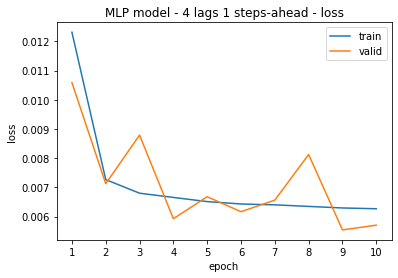

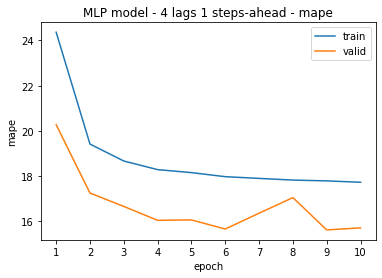

MLP model - 4 lags 1 steps-ahead - train min loss: 0.006269	mae: 0.055879	mape: 17.728977	epoch: 10
MLP model - 4 lags 1 steps-ahead - valid min loss: 0.005545	mae: 0.052778	mape: 15.621608	epoch: 9



In [82]:
def compile_fit_validate(model, train, valid, optimizer, epochs = 5, verbose = 2):
    # Reduces variance in results but won't eliminate it :-(
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)
    
    if optimizer.lower() == 'adadelta':
        opt = Adadelta(lr = 1.0)
    else:
        opt = Adam(lr = 0.001)
        
    es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)
    lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, min_lr = 0.0001)

    model.compile(optimizer = opt, loss = 'mse', metrics = ['mae', 'mape'])    
    h = model.fit(train, validation_data = valid,
                  epochs = epochs, verbose = verbose, callbacks = [es, lr])
    
    return h

    
def plot_history(h, name, epochs = 10):
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.xticks(range(0, epochs), labels = range(1, epochs + 1))
    plt.title(name + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc = 'upper right')
    plt.show()

    plt.plot(h.history['mape'])
    plt.plot(h.history['val_mape'])
    plt.xticks(range(0, epochs), labels = range(1, epochs + 1))
    plt.title(name + ' mape')
    plt.ylabel('mape')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc = 'upper right')
    plt.show();

    
def print_min_loss(h, name):
    argmin_loss     = np.argmin(np.array(h.history['loss']))
    argmin_val_loss = np.argmin(np.array(h.history['val_loss']))
    min_loss        = h.history['loss'][argmin_loss]
    min_val_loss    = h.history['val_loss'][argmin_val_loss]
    mape            = h.history['mape'][argmin_loss]
    val_mape        = h.history['val_mape'][argmin_val_loss]
    mae             = h.history['mae'][argmin_loss]
    val_mae         = h.history['val_mae'][argmin_val_loss]
    
    txt = "{0:s} {1:s} min loss: {2:f}\tmae: {3:f}\tmape: {4:f}\tepoch: {5:d}"
    print(txt.format(name, "train", min_loss,     mae,     mape,     argmin_loss + 1))
    print(txt.format(name, "valid", min_val_loss, val_mae, val_mape, argmin_val_loss + 1))
    print()


def get_io_shapes(data):
    for batch in data.take(1):
        in_shape  = batch[0][0].shape
        out_shape = batch[1][0].shape
        
    return in_shape, out_shape


# For testing compile_fit_validate, plot_progress etc
def build_small_model(name, data):
    in_shape, _ = get_io_shapes(data)
    
    small = Sequential(name = name)
    
    small.add(Input(shape = in_shape))
    
    small.add(Dense(64, activation = 'relu'))
    small.add(Dense(64, activation = 'relu'))
    
    small.add(Dense(1))    
    
    return small


def build_mlp_model_orig(name, data, n):
    in_shape, _ = get_io_shapes(data)
    
    mlp = Sequential(name = name)
    
    mlp.add(Input(shape = in_shape))
    mlp.add(Flatten())  # Shape: (time, features) => (time*features)
    mlp.add(Dropout(0.1))
    
    mlp.add(Dense(500, activation = 'relu'))
    mlp.add(Dropout(0.2))
    
    mlp.add(Dense(500, activation = 'relu'))
    mlp.add(Dropout(0.2))
    
    mlp.add(Dense(500, activation = 'relu'))
    mlp.add(Dropout(0.3))
    
    mlp.add(Dense(1))   
    mlp.add(Reshape([1, -1]))
    
    return mlp


def build_mlp_model(name, data, neurons = 64):
    in_shape, _ = get_io_shapes(data)
    
    mlp = Sequential(name = name)
    
    mlp.add(Input(shape = in_shape))
    mlp.add(Flatten())  # Shape: (time, features) => (time*features)
    # mlp.add(Dropout(0.1))
    
    mlp.add(Dense(neurons, activation = 'relu'))
    # mlp.add(Dropout(0.1))
    
    mlp.add(Dense(neurons, activation = 'relu'))
    # mlp.add(Dropout(0.1))
    
    # mlp.add(Dense(neurons, activation = 'relu'))
    # mlp.add(Dropout(0.1))
    
    mlp.add(Dense(1))   
    mlp.add(Reshape([1, -1]))
    
    return mlp


def run_model(model, train, valid, optimizer = 'adam', epochs = 5):
    in_shape, out_shape = get_io_shapes(train)
    model_id = model.name + ' model - ' + str(in_shape[0]) + \
               ' lags ' + str(out_shape[0]) + ' steps-ahead -'
    
    model.summary()
    h = compile_fit_validate(model, train, valid, optimizer, epochs)
    plot_history(h, model_id, epochs)
    print_min_loss(h, model_id)
    
    return h


#ds_train_4l_1s, ds_valid_4l_1s, ds_test_4l_1s = make_datasets(train_df, valid_df, test_df, 
#                                                              lags = 4, shuffle = True, bs = 4)
 
name = 'MLP'
#mlp_1l_1s   = build_mlp_model(name, ds_train_1l_1s)
#h_mlp_1l_1s = run_model(mlp_1l_1s, ds_train_1l_1s, ds_valid_1l_1s, optimizer = 'adadelta', epochs = 20)
mlp_4l_1s   = build_mlp_model(name, ds_train_4l_1s)
h_mlp_4l_1s = run_model(mlp_4l_1s, ds_train_4l_1s, ds_valid_4l_1s, optimizer = 'adadelta', epochs = 10)
#mlp_8l_1s   = build_mlp_model(name, ds_train_8l_1s)
#h_mlp_8l_1s = run_model(mlp_8l_1s, ds_train_8l_1s, ds_valid_8l_1s, optimizer = 'adadelta', epochs = 20)
#mlp_16l_1s   = build_mlp_model(name, ds_train_16l_1s)
#h_mlp_16l_1s = run_model(mlp_16l_1s, ds_train_16l_1s, ds_valid_16l_1s, optimizer = 'adadelta', epochs = 20)
#mlp_24l_1s   = build_mlp_model(name, ds_train_24l_1s)
#h_mlp_24l_1s = run_model(mlp_24l_1s, ds_train_24l_1s, ds_valid_24l_1s, optimizer = 'adadelta', epochs = 20)
#mlp_32l_1s   = build_mlp_model(name, ds_train_32l_1s)
#h_mlp_32l_1s = run_model(mlp_32l_1s, ds_train_32l_1s, ds_valid_32l_1s, optimizer = 'adadelta', epochs = 20)
#mlp_40l_1s   = build_mlp_model(name, ds_train_40l_1s)
#h_mlp_40l_1s = run_model(mlp_40l_1s, ds_train_40l_1s, ds_valid_40l_1s, optimizer = 'adadelta', epochs = 20)
#mlp_48l_1s   = build_mlp_model(name, ds_train_48l_1s)
#h_mlp_48l_1s = run_model(mlp_48l_1s, ds_train_48l_1s, ds_valid_48l_1s, optimizer = 'adadelta', epochs = 20)

Second, check multiple time-steps.

In [ ]:
#mlp_1l_4s   = build_mlp_model(name, ds_train_1l_4s)
#h_mlp_1l_4s = run_model(mlp_1l_4s, ds_train_1l_4s, ds_valid_1l_4s, optimizer = 'adadelta', epochs = 20)
mlp_4l_4s   = build_mlp_model(name, ds_train_4l_4s)
h_mlp_4l_4s = run_model(mlp_4l_4s, ds_train_4l_4s, ds_valid_4l_4s, optimizer = 'adadelta', epochs = 20)
#mlp_8l_4s   = build_mlp_model(name, ds_train_8l_4s)
#h_mlp_8l_4s = run_model(mlp_8l_4s, ds_train_8l_4s, ds_valid_8l_4s, optimizer = 'adadelta', epochs = 20)
#mlp_16l_4s   = build_mlp_model(name, ds_train_16l_4s)
#h_mlp_16l_4s = run_model(mlp_16l_4s, ds_train_16l_4s, ds_valid_16l_4s, optimizer = 'adadelta', epochs = 20)
#mlp_24l_4s   = build_mlp_model(name, ds_train_24l_4s)
#h_mlp_24l_4s = run_model(mlp_24l_4s, ds_train_24l_4s, ds_valid_24l_4s, optimizer = 'adadelta', epochs = 20)
#mlp_32l_4s   = build_mlp_model(name, ds_train_32l_4s)
#h_mlp_32l_4s = run_model(mlp_32l_4s, ds_train_32l_4s, ds_valid_32l_4s, optimizer = 'adadelta', epochs = 20)
#mlp_40l_4s   = build_mlp_model(name, ds_train_40l_4s)
#h_mlp_40l_4s = run_model(mlp_40l_4s, ds_train_40l_4s, ds_valid_40l_4s, optimizer = 'adadelta', epochs = 20)
#mlp_48l_4s   = build_mlp_model(name, ds_train_48l_4s)
#h_mlp_48l_4s = run_model(mlp_48l_4s, ds_train_48l_4s, ds_valid_48l_4s, optimizer = 'adadelta', epochs = 20)

### Fully convolutional network

See [Time Series Classification from Scratch with Deep Neural Networks: A Strong Baseline](https://arxiv.org/abs/1611.06455)
for a detailed description of the Fully Convolutional Network (FCN) architecture.  The FCN
was first described in
[Time-series modeling with undecimated fully convolutional neural networks](https://arxiv.org/abs/1508.00317).

The FCN architecture is a variant of the Convolutional Neural Network (CNN).  A Convolutional 
Neural Network (CNN) usually contains fully-connected layers or a MLP at the 
end of the network.  The FCN does not include these final layers, so it is learning 
convolutional filters everywhere.

**TODO** Include figure comparing FCNs and CNNs

The Keras [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)
layer is used for temporal convolution.

First, check single step-ahead predictions.

Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 24, 64)            5184      
_________________________________________________________________
batch_normalization_27 (Batc (None, 24, 64)            256       
_________________________________________________________________
activation_21 (Activation)   (None, 24, 64)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 24, 64)            20544     
_________________________________________________________________
batch_normalization_28 (Batc (None, 24, 64)            256       
_________________________________________________________________
activation_22 (Activation)   (None, 24, 64)            0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 24, 64)            12352   

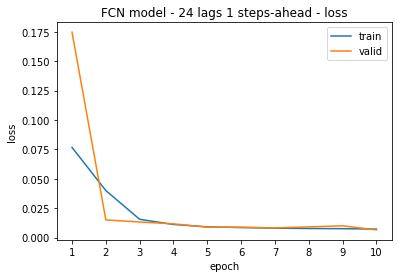

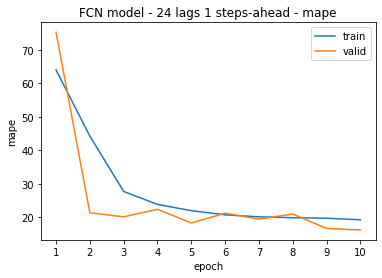

FCN model - 24 lags 1 steps-ahead - train min loss: 0.007266	mae: 0.061762	mape: 19.232582	epoch: 10
FCN model - 24 lags 1 steps-ahead - valid min loss: 0.006545	mae: 0.058376	mape: 16.199995	epoch: 10



In [78]:
def build_fcn_model_orig(name, data):
    in_shape, _ = get_io_shapes(data)
    
    fcn = Sequential(name = name)
    fcn.add(Input(shape = in_shape))
    
    fcn.add(Conv1D(filters = 128, kernel_size = 8, padding = 'same'))
    fcn.add(BatchNormalization())
    fcn.add(Activation(activation = 'relu'))

    fcn.add(Conv1D(filters = 256, kernel_size = 5, padding = 'same'))
    fcn.add(BatchNormalization())
    fcn.add(Activation(activation = 'relu'))

    fcn.add(Conv1D(filters = 128, kernel_size = 3, padding = 'same'))
    fcn.add(BatchNormalization())
    fcn.add(Activation(activation = 'relu'))

    fcn.add(GlobalAveragePooling1D())
    fcn.add(Dense(1))

    return fcn


def build_fcn_model(name, data, n_feature_maps = 64):
    in_shape, _ = get_io_shapes(data)
    
    fcn = Sequential(name = name)
    fcn.add(Input(shape = in_shape))
    
    fcn.add(Conv1D(filters = n_feature_maps, kernel_size = 8, padding = 'same'))
    fcn.add(BatchNormalization())
    fcn.add(Activation(activation = 'relu'))

    fcn.add(Conv1D(filters = n_feature_maps, kernel_size = 5, padding = 'same'))
    fcn.add(BatchNormalization())
    fcn.add(Activation(activation = 'relu'))

    fcn.add(Conv1D(filters = n_feature_maps, kernel_size = 3, padding = 'same'))
    fcn.add(BatchNormalization())
    fcn.add(Activation(activation = 'relu'))

    fcn.add(GlobalAveragePooling1D())
    fcn.add(Dense(1))

    return fcn


name = 'FCN'
#fcn_1l_1s   = build_fcn_model(name, ds_train_1l_1s)
#h_fcn_1l_1s = run_model(fcn_1l_1s, ds_train_1l_1s, ds_valid_1l_1s, epochs = 20)
#fcn_4l_1s   = build_fcn_model(name, ds_train_4l_1s)
#h_fcn_4l_1s = run_model(fcn_4l_1s, ds_train_4l_1s, ds_valid_4l_1s, epochs = 20)
#fcn_8l_1s   = build_fcn_model(name, ds_train_8l_1s)
#h_fcn_8l_1s = run_model(fcn_8l_1s, ds_train_8l_1s, ds_valid_8l_1s, epochs = 20)
#fcn_16l_1s   = build_fcn_model(name, ds_train_16l_1s)
#h_fcn_16l_1s = run_model(fcn_16l_1s, ds_train_16l_1s, ds_valid_16l_1s, epochs = 20)
fcn_24l_1s   = build_fcn_model(name, ds_train_24l_1s)
h_fcn_24l_1s = run_model(fcn_24l_1s, ds_train_24l_1s, ds_valid_24l_1s, epochs = 10)
#fcn_32l_1s   = build_fcn_model(name, ds_train_32l_1s)
#h_fcn_32l_1s = run_model(fcn_32l_1s, ds_train_32l_1s, ds_valid_32l_1s, epochs = 20)
#fcn_40l_1s   = build_fcn_model(name, ds_train_40l_1s)
#h_fcn_40l_1s = run_model(fcn_40l_1s, ds_train_40l_1s, ds_valid_40l_1s, epochs = 20)
#fcn_48l_1s   = build_fcn_model(name, ds_train_48l_1s)
#h_fcn_48l_1s = run_model(fcn_48l_1s, ds_train_48l_1s, ds_valid_48l_1s, epochs = 20)

Second, check multiple step-ahead predictions.

In [ ]:
#fcn_1l_4s   = build_fcn_model(name, ds_train_1l_4s)
#h_fcn_1l_4s = run_model(fcn_1l_4s, ds_train_1l_4s, ds_valid_1l_4s, epochs = 20)
#fcn_4l_4s   = build_fcn_model(name, ds_train_4l_4s)
#h_fcn_4l_4s = run_model(fcn_4l_4s, ds_train_4l_4s, ds_valid_4l_4s, epochs = 20)
#fcn_8l_4s   = build_fcn_model(name, ds_train_8l_4s)
#h_fcn_8l_4s = run_model(fcn_8l_4s, ds_train_8l_4s, ds_valid_8l_4s, epochs = 20)
#fcn_16l_4s   = build_fcn_model(name, ds_train_16l_4s)
#h_fcn_16l_4s = run_model(fcn_16l_4s, ds_train_16l_4s, ds_valid_16l_4s, epochs = 20)
fcn_24l_4s   = build_fcn_model(name, ds_train_24l_1s)
h_fcn_24l_4s = run_model(fcn_24l_1s, ds_train_24l_1s, ds_valid_24l_1s, epochs = 20)
#fcn_32l_4s   = build_fcn_model(name, ds_train_32l_4s)
#h_fcn_32l_4s = run_model(fcn_32l_4s, ds_train_32l_4s, ds_valid_32l_4s, epochs = 20)
#fcn_40l_4s   = build_fcn_model(name, ds_train_40l_4s)
#h_fcn_40l_4s = run_model(fcn_40l_4s, ds_train_40l_4s, ds_valid_40l_4s, epochs = 20)
#fcn_48l_4s   = build_fcn_model(name, ds_train_48l_4s)
#h_fcn_48l_4s = run_model(fcn_48l_4s, ds_train_48l_4s, ds_valid_48l_4s, epochs = 20)

### Residual network

Residual networks, or ResNets, were originally proposed in
[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385).

Residual neural networks use "identity shortcut connections" to skip over some layers.  Typical ResNet models are implemented with blocks of layer that contain nonlinearities (ReLU) and batch normalization.
Skipping over layers may avoid the problem of vanishing gradients, by reusing activations from a previous layer until the adjacent layer learns its weights.  This should allow training networks with more layers.

**TODO** Include basic ResNet diagram

Again, the Keras [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)
layer is used for temporal convolution.

First, check single step-ahead predictions.

In [77]:
 def build_resnet_model(name, data, n_feature_maps = 64):
    in_shape, _ = get_io_shapes(data)
        
    input_layer = keras.layers.Input(in_shape)
    
    # BLOCK 1
    conv_x = keras.layers.Conv1D(filters = n_feature_maps, kernel_size = 8, padding = 'same')(input_layer)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters = n_feature_maps, kernel_size = 5, padding = 'same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters = n_feature_maps, kernel_size = 3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters = n_feature_maps, kernel_size = 1, padding = 'same')(input_layer)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_1 = keras.layers.add([shortcut_y, conv_z])
    output_block_1 = keras.layers.Activation('relu')(output_block_1)

        
    # BLOCK 2
    conv_x = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 8, padding = 'same')(output_block_1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 5, padding = 'same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 3, padding = 'same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 1, padding = 'same')(output_block_1)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_z])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)

        
    # BLOCK 3
    conv_x = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 8, padding = 'same')(output_block_2)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 5, padding = 'same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 3, padding = 'same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = keras.layers.BatchNormalization()(output_block_2)

    output_block_3 = keras.layers.add([shortcut_y, conv_z])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)

    # FINAL
    gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)
    output_layer = keras.layers.Dense(1)(gap_layer)
    resnet = keras.models.Model(name = name, inputs = input_layer, outputs = output_layer)

    return resnet
   

name = 'ResNet'
#resnet_1l_1s   = build_resnet_model(name, ds_train_1l_1s)
#h_resnet_1l_1s = run_model(resnet_1l_1s, ds_train_1l_1s, ds_valid_1l_1s, epochs = 20)
#resnet_4l_1s   = build_resnet_model(name, ds_train_4l_1s)
#h_resnet_4l_1s = run_model(resnet_4l_1s, ds_train_4l_1s, ds_valid_4l_1s, epochs = 20)
#resnet_8l_1s   = build_resnet_model(name, ds_train_8l_1s)
#h_resnet_8l_1s = run_model(resnet_8l_1s, ds_train_8l_1s, ds_valid_8l_1s, epochs = 20)
#resnet_16l_1s   = build_resnet_model(name, ds_train_16l_1s)
#h_resnet_16l_1s = run_model(resnet_16l_1s, ds_train_16l_1s, ds_valid_16l_1s, epochs = 20)
resnet_24l_1s   = build_resnet_model(name, ds_train_24l_1s)
h_resnet_24l_1s = run_model(resnet_24l_1s, ds_train_24l_1s, ds_valid_24l_1s, epochs = 10)
#resnet_32l_1s   = build_resnet_model(name, ds_train_32l_1s)
#h_resnet_32l_1s = run_model(resnet_32l_1s, ds_train_32l_1s, ds_valid_32l_1s, epochs = 20)
#resnet_40l_1s   = build_resnet_model(name, ds_train_40l_1s)
#h_resnet_40l_1s = run_model(resnet_40l_1s, ds_train_40l_1s, ds_valid_40l_1s, epochs = 20)
#resnet_48l_1s   = build_resnet_model(name, ds_train_48l_1s)
#h_resnet_48l_1s = run_model(resnet_48l_1s, ds_train_48l_1s, ds_valid_48l_1s, epochs = 20)

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 24, 10)]     0                                            
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 24, 64)       5184        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 24, 64)       256         conv1d_14[0][0]                  
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 24, 64)       0           batch_normalization_15[0][0]     
_____________________________________________________________________________________________

Epoch 1/10
4991/4991 - 472s - loss: 0.0497 - mae: 0.1505 - mape: 48.0512 - val_loss: 0.0195 - val_mae: 0.1104 - val_mape: 22.7655
Epoch 2/10


KeyboardInterrupt: 

Second, check multiple step-ahead predictions.

In [ ]:
#resnet_1l_4s   = build_resnet_model(name, ds_train_1l_4s)
#h_resnet_1l_4s = run_model(resnet_1l_4s, ds_train_1l_4s, ds_valid_1l_4s, epochs = 20)
#resnet_4l_4s   = build_resnet_model(name, ds_train_4l_4s)
#h_resnet_4l_4s = run_model(resnet_4l_4s, ds_train_4l_4s, ds_valid_4l_4s, epochs = 20)
#resnet_8l_4s   = build_resnet_model(name, ds_train_8l_4s)
#h_resnet_8l_4s = run_model(resnet_8l_4s, ds_train_8l_4s, ds_valid_8l_4s, epochs = 20)
#resnet_16l_4s   = build_resnet_model(name, ds_train_16l_4s)
#h_resnet_16l_4s = run_model(resnet_16l_4s, ds_train_16l_4s, ds_valid_16l_4s, epochs = 20)
resnet_24l_4s   = build_resnet_model(name, ds_train_24l_4s)
h_resnet_24l_4s = run_model(resnet_24l_4s, ds_train_24l_4s, ds_valid_24l_4s, epochs = 20)
#resnet_32l_4s   = build_resnet_model(name, ds_train_32l_4s)
#h_resnet_32l_4s = run_model(resnet_32l_4s, ds_train_32l_4s, ds_valid_32l_4s, epochs = 20)
#resnet_40l_4s   = build_resnet_model(name, ds_train_40l_4s)
#h_resnet_40l_4s = run_model(resnet_40l_4s, ds_train_40l_4s, ds_valid_40l_4s, epochs = 20)
#resnet_48l_4s   = build_resnet_model(name, ds_train_48l_4s)
#h_resnet_48l_4s = run_model(resnet_48l_4s, ds_train_48l_4s, ds_valid_48l_4s, epochs = 20)

### Architecture comparison and/or optimisation

...

Using `ds_test_1s` and `ds_test_4s`.

Plot residuals of optimised model.

Plot some forecasts?

Optimisation with [keras-tuner](https://github.com/keras-team/keras-tuner)?

...

---


## Conclusion

...

Compare with baselines and/or prophet results?

Future work
 * consider using 2018 data for validation and 2019 for testing
   * testing & validation should be carried out over an entire year of data
   * check amount of missing data (from cleaning) during 2018 & 2019
 * consider not using incomplete 2008 data
   * 2008 data starts on August 1st
   * if 2018 & 2019 are used for validation & testing, then the months August to December will be over-represented 
 * decorrelate input variables
   * deseasonalise (daily & annual) pressure, humidity, wind etc
 * data augmentation/regularisation with a method like [mixup](https://arxiv.org/abs/1710.09412) may be beneficial for the quantised $x$ and $y$ wind vectors
   * mixup may need to be applied between consecutive observations for time series 
 * move some code to module(s) for reuse
   * particularly data prep
 * ...

...

---

## Metadata

Python and Jupyter versions plus modules imported and their version strings. 
This is the poor man's python equivalent of R's sessionInfo().

Code for imported modules and versions adapted from this stackoverflow answer. 
There are simpler alternatives, such as watermark, but they all require installation.

In [ ]:
import sys
import IPython

print("Python version:")
print(sys.executable)
print(sys.version)
print("\nIPython version:")
print(IPython.__version__)

In [ ]:
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names.  Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name.  You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL":       "Pillow",
            "sklearn":   "scikit-learn",
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

reqs = pd.DataFrame(requirements, columns = ['name', 'version'])
print("Imported modules:")
reqs.style.hide_index()

In [ ]:
!date

---


## Archival

Archive code, markdown, history and formatted notebooks.

Assumes all pdf, html, latex etc dependencies are installed.

**WARNING** Will overwrite existing files.

Notebook name is hardcoded below because the alternative is ghastly globs of unreliable javascript or external ipython libraries I'd prefer to avoid installing :-(

In [ ]:
from time import sleep

notebook = "keras_mlp_fcn_resnet_time_series.ipynb"
# !jupyter nbconvert --to script {notebook}
# !jupyter nbconvert --execute --to html {notebook}
# !jupyter nbconvert --execute --to pdf {notebook}
# !jupyter nbconvert --to pdf {notebook}

%rm history.txt
%history -f history.txt

!jupyter nbconvert --to python {notebook}
sleep(5)
!jupyter nbconvert --to markdown {notebook}
sleep(5)
!jupyter nbconvert --to html {notebook}